In [1]:
!git clone https://github.com/pratikkayal/PlantDoc-Dataset

Cloning into 'PlantDoc-Dataset'...

remote: Enumerating objects: 2670, done.

remote: Counting objects: 100% (42/42), done.

remote: Compressing objects: 100% (20/20), done.

remote: Total 2670 (delta 23), reused 40 (delta 22), pack-reused 2628 (from 1)

Receiving objects: 100% (2670/2670), 932.92 MiB | 17.04 MiB/s, done.

Resolving deltas: 100% (24/24), done.

Updating files: 100% (2581/2581), done.


In [2]:
import os
from PIL import Image
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

In [10]:
class MSA(torch.nn.Module):
    """
    This is the template implementation of the "Multi-Scale Attention" Layer.

    The query, key and value mapping are matrix-multipled against each other in order to
    find the attention, or, the relation of a word and its interaction with surrounding words.
    """
    def __init__(self, d, n_heads=4):
        super(MSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0  # Shouldn't divide dimension (d) into n_heads

        d_head = int(d / n_heads)
        self.q_mappings = torch.nn.ModuleList([torch.nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = torch.nn.ModuleList([torch.nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = torch.nn.ModuleList([torch.nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = torch.nn.Softmax(dim=-1)

    def forward(self, sequences):
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

In [11]:
class ViT(torch.nn.Module):
    """
    The workflow will be as follows.
        1. Find the linear mapping of the input
        2. Embed them using the function that we have written
        3. Use 'n' MSA blocks and add a linear and a softmax layer at the end
    """

    def __init__(self, chw, n_patches=16, n_blocks=2, hidden_d=8, n_heads=4, out_d=10):
        super(ViT, self).__init__()

        self.chw = chw
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d

        # Input and patch sizes
        assert chw[1] % n_patches == 0
        assert chw[2] % n_patches == 0
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # Linear mapping
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = torch.nn.Linear(self.input_d, self.hidden_d)

        # Classification token
        self.v_class = torch.nn.Parameter(torch.rand(1, self.hidden_d))

        # Positional embedding
        self.register_buffer('pos_embeddings', self.positional_embeddings(n_patches ** 2 + 1, hidden_d),
                             persistent=False)

        # Encoder blocks
        self.blocks = torch.nn.ModuleList([MSA(hidden_d, n_heads) for _ in range(n_blocks)])

        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(self.hidden_d, out_d),
            torch.nn.Softmax(dim=-1)
        )

    def patchify(self, images, n_patches):
        """
        In order to "sequentially" pass in the images, we can break down the main image into multiple sub-images
        and map them to a vector. This is exactly what this function does.

        Arguments:
        images: The image passed into this function
        n_patches: The number of patches to split the image into.

        Returns our patches aka the sub-images.
        """
        n, c, h, w = images.shape

        assert h == w, "Only for square images"

        patches = torch.zeros(n, n_patches ** 2, h * w * c // n_patches ** 2)
        patch_size = h // n_patches

        for idx, image in enumerate(images):
            for i in range(n_patches):
                for j in range(n_patches):
                    patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
                    patches[idx, i * n_patches + j] = patch.flatten()
        return patches

    def positional_embeddings(self, sequence_length, d):
        """
        In order for the model to know where to place each image, one can use positional embeddings where high freq values
        are classified into the first few dimensions while low frequency values are added on to the latter dimensions. This
        function performs exactly that. It has two parameters.

        Arguments:
        sequence_length: The number of tokens for the dataset.
        d: The dimensionality for each token.

        Returns a matrix where each (i,j) is added as token i in dimension j.
        """
        result = torch.ones(sequence_length, d)
        for i in range(sequence_length):
            for j in range(d):
                result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** (j / d)))
        return result

    def forward(self, images):
        n, c, h, w = images.shape
        patches = self.patchify(images, self.n_patches).to(self.pos_embeddings.device)

        # rutorch.nning tokenization
        tokens = self.linear_mapper(patches)
        tokens = torch.cat((self.v_class.expand(n, 1, -1), tokens), dim=1)
        out = tokens + self.pos_embeddings.repeat(n, 1, 1)

        for block in self.blocks:
            out = block(out)

        out = out[:, 0]
        return self.mlp(out)

In [14]:
!pip install lightning watermark























  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)














  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)


  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)


  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)


  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)


  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)


  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)


  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)


  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)


  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)


  Using cached nvidia_nccl_cu1

In [84]:
import lightning as L
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn.functional as F
import torchmetrics
from torch.utils.data import DataLoader ,Subset
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms
import numpy as np
def split_indices(n,val_pct=0.1,test_pct=0.2,seed=99):
    n_val=int(val_pct*n)
    n_test=int(test_pct*n)
    np.random.seed(seed)
    idxs=np.random.permutation(n)
    return idxs[:n_val],idxs[n_val:n_val+n_test],idxs[n_val+n_test:]


class LightningViT(L.LightningModule):
    def __init__(self, chw, n_patches=16, n_blocks=2, hidden_d=8, n_heads=4, out_d=10, learning_rate=1e-3):
        super().__init__()

        self.learning_rate = learning_rate
        self.model = ViT(chw, n_patches, n_blocks, hidden_d, n_heads, out_d)

        self.save_hyperparameters(ignore=["model"])

        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=out_d)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=out_d)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=out_d)

    def forward(self, x):
        return self.model(x)

    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)

        loss = F.cross_entropy(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim=1)
        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("train_loss", loss)
        self.train_acc(predicted_labels, true_labels)
        self.log(
            "train_acc", self.train_acc, prog_bar=True, on_epoch=True, on_step=False
        )
        return loss

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("val_loss", loss, prog_bar=True)
        self.val_acc(predicted_labels, true_labels)
        self.log("val_acc", self.val_acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=( self.learning_rate))
        return optimizer

class PlantDoc(L.LightningDataModule):
    def __init__(
        self,
        data_path="PlantDoc-Dataset",
        batch_size=256,
        height_width=None,
        num_workers=0,
        train_transform=None,
        test_transform=None,
    ):
        super().__init__()
        self.batch_size = batch_size
        self.data_path = data_path
        self.num_workers = num_workers
        self.train_transform = train_transform
        self.test_transform = test_transform
        self.height_width = height_width

    def prepare_data(self):
        if self.height_width is None:
            self.height_width = (100, 100)

        if self.train_transform is None:
            self.train_transform = transforms.Compose(
                [
                    transforms.Resize(self.height_width),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomResizedCrop(self.height_width[0]),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ]
            )

        if self.test_transform is None:
            self.test_transform = transforms.Compose(
                [
                    transforms.Resize(self.height_width),
                    transforms.CenterCrop(self.height_width[0]),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ]
            )

    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            full_dataset = datasets.ImageFolder(
                root=f"{self.data_path}/train",
                transform=self.train_transform
            )

            train_size = int(0.8 * len(full_dataset))
            val_size = len(full_dataset) - train_size

            self.train, self.valid = random_split(full_dataset, [train_size, val_size])

        if stage == 'test' or stage is None:
            self.test = datasets.ImageFolder(
                root=f"{self.data_path}/test",
                transform=self.test_transform
            )

    def train_dataloader(self):
        return DataLoader(
            self.train,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            drop_last=True
        )

    def val_dataloader(self):
        return DataLoader(
            self.valid,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            drop_last=False
        )

    def test_dataloader(self):
        return DataLoader(
            self.test,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            drop_last=False
        )




def plot_loss_and_acc(
    log_dir, loss_ylim=(0.0, 0.9), acc_ylim=(0.7, 1.0), save_loss=None, save_acc=None
):

    metrics = pd.read_csv(f"{log_dir}/metrics.csv")

    aggreg_metrics = []
    agg_col = "epoch"
    for i, dfg in metrics.groupby(agg_col):
        agg = dict(dfg.mean())
        agg[agg_col] = i
        aggreg_metrics.append(agg)

    df_metrics = pd.DataFrame(aggreg_metrics)
    df_metrics[["train_loss", "val_loss"]].plot(
        grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
    )

    plt.ylim(loss_ylim)
    if save_loss is not None:
        plt.savefig(save_loss)

    df_metrics[["train_acc", "val_acc"]].plot(
        grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
    )

    plt.ylim(acc_ylim)
    if save_acc is not None:
        plt.savefig(save_acc)

In [85]:
import lightning as L
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
from lightning.pytorch.loggers import CSVLogger
import matplotlib.pyplot as plt
import numpy as np


In [86]:
!pip install wandb
import wandb
!wandb login  9eab9029c1033a5956bf6721a6933ebfbeb865fd

wandb: Currently logged in as: sanjay7178 (mphoenix). Use `wandb login --relogin` to force relogin


True

In [87]:
from lightning.pytorch.loggers import WandbLogger

wandb_logger = WandbLogger(project="plant_doc")

In [91]:
from lightning.pytorch.callbacks import ModelCheckpoint ,BatchSizeFinder 

class FineTuneBatchSizeFinder(BatchSizeFinder):
    def __init__(self, milestones, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.milestones = milestones

    def on_fit_start(self, *args, **kwargs):
        return

    def on_train_epoch_start(self, trainer, pl_module):
        if trainer.current_epoch in self.milestones or trainer.current_epoch == 0:
            self.scale_batch_size(trainer, pl_module)

class EvalBatchSizeFinder(BatchSizeFinder):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def on_fit_start(self, *args, **kwargs):
        return

    def on_test_start(self, trainer, pl_module):
        self.scale_batch_size(trainer, pl_module)


callbacks = [
    ModelCheckpoint(save_top_k=1, mode="max", monitor="val_acc", save_last=True) 
    # ,FineTuneBatchSizeFinder(milestones=(5, 10))
    # , EvalBatchSizeFinder()
]

In [89]:
%%capture --no-display

L.pytorch.seed_everything(123)

dm = PlantDoc(batch_size=1024, num_workers=2,
                       train_transform=None,
                       test_transform=None)

lightning_model = LightningViT((3, 100, 100), n_patches=10, n_blocks=2, hidden_d=8, n_heads=2, out_d=28, learning_rate=0.01445439770745928)


trainer = L.Trainer(
    callbacks=callbacks,
    max_epochs=500,
    accelerator="gpu",
    devices=[0],
#     logger=CSVLogger(save_dir="/kaggle/working/logs/", name="plant_doc1"),
    logger=wandb_logger,
    deterministic=False,
    log_every_n_steps=10
)

INFO: Seed set to 123

INFO:lightning.fabric.utilities.seed:Seed set to 123

INFO: GPU available: True (cuda), used: True

INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True

INFO: TPU available: False, using: 0 TPU cores

INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores

INFO: HPU available: False, using: 0 HPUs

INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=100` reached.

INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.

INFO: Learning rate set to 0.01445439770745928

INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.01445439770745928

INFO: Restoring states from the checkpoint path at /content/.lr_find_72e25fe7-2b6c-4646-a5c1-8bce980ca37e.ckpt

INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_72e25fe7-2b6c-4646-a5c1-8bce980ca37e.ckpt

INFO: Restored all states from the checkpoint at /content/.lr_find_72e25fe7-2b6c-4646-a5c1-8bce980ca37e.ckpt

INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_72e25fe7-2b6c-4646-a5c1-8bce980ca37e.ckpt


{'lr': [1e-08, 1.4454397707459274e-08, 1.7378008287493753e-08, 2.0892961308540398e-08, 2.51188643150958e-08, 3.019951720402016e-08, 3.630780547701014e-08, 4.36515832240166e-08, 5.248074602497726e-08, 6.309573444801934e-08, 7.585775750291837e-08, 9.120108393559096e-08, 1.0964781961431852e-07, 1.3182567385564074e-07, 1.5848931924611133e-07, 1.9054607179632475e-07, 2.2908676527677735e-07, 2.7542287033381663e-07, 3.311311214825911e-07, 3.9810717055349735e-07, 4.786300923226383e-07, 5.75439937337157e-07, 6.918309709189366e-07, 8.317637711026709e-07, 1e-06, 1.2022644346174132e-06, 1.445439770745928e-06, 1.7378008287493761e-06, 2.089296130854039e-06, 2.5118864315095797e-06, 3.0199517204020163e-06, 3.630780547701014e-06, 4.365158322401661e-06, 5.248074602497728e-06, 6.3095734448019305e-06, 7.585775750291836e-06, 9.120108393559096e-06, 1.0964781961431852e-05, 1.3182567385564076e-05, 1.584893192461114e-05, 1.9054607179632464e-05, 2.2908676527677725e-05, 2.7542287033381663e-05, 3.311311214825911e

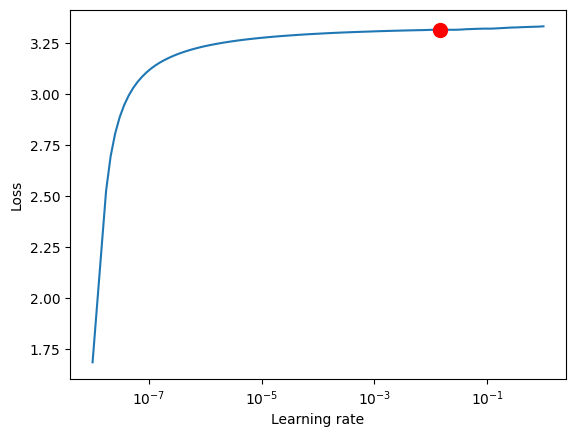

In [90]:
# from lightning.pytorch.tuner import Tuner
# # trainer = Trainer()
# tuner = Tuner(trainer)

# # Run learning rate finder
# lr_finder = tuner.lr_find(lightning_model,datamodule=dm)

# # Results can be found in
# print(lr_finder.results)

# # Plot with
# fig = lr_finder.plot(suggest=True)
# fig.show()

# # Pick point based on plot, or get suggestion
# new_lr = lr_finder.suggestion()

# update hparams of the model
# lightning_model.hparams.lr = new_lr
# lightning_model.hparams.lr = 0.01445439770745928

In [69]:
# torch.use_deterministic_algorithms(False)

In [ ]:
# !export CUBLAS_WORKSPACE_CONFIG=:4096:8
trainer.fit(model=lightning_model, datamodule=dm)


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

INFO: 

  | Name      | Type               | Params | Mode 

---------------------------------------------------------

0 | model     | ViT                | 2.9 K  | train

1 | train_acc | MulticlassAccuracy | 0      | train

2 | val_acc   | MulticlassAccuracy | 0      | train

3 | test_acc  | MulticlassAccuracy | 0      | train

---------------------------------------------------------

2.9 K     Trainable params

0         Non-trainable params

2.9 K     Total params

0.012     Total estimated model params size (MB)

31        Modules in train mode

0         Modules in eval mode

INFO:lightning.pytorch.callbacks.model_summary:

  | Name      | Type               | Params | Mode 

---------------------------------------------------------

0 | model     | ViT                | 2.9 K  | train

1 | train_acc | MulticlassAccuracy | 0      | train

2 | val_ac

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
plot_loss_and_acc(trainer.logger.log_dir, loss_ylim=(0.0, 2.0))


In [ ]:
trainer.test(model=lightning_model, datamodule=dm)


In [ ]:
trainer.test(model=lightning_model, datamodule=dm, ckpt_path="best")


In [ ]:
trainer.test(model=lightning_model, datamodule=dm, ckpt_path="last")


In [ ]:
path = trainer.checkpoint_callback.best_model_path

lightning_model = LightningModel.load_from_checkpoint(
    path, learning_rate=0.1, model=pytorch_model
)
lightning_model.eval();

trainer.test(model=lightning_model, datamodule=dm)

In [ ]:
torch.save(pytorch_model.state_dict(), "/kaggle/working/vit.pt")
